In [1]:
import numpy as np
import retworkx as rx
import pandas as pd
import os
import time
import math
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor
import matplotlib.pyplot as plt

# get the current directory
cur_dir = os.getcwd()

# Import the dataset
df = pd.read_csv(os.path.join(cur_dir, '../../Datasets/normalized_heart_slimmed.csv'), header=0)

# split into x, y
X, y = df.drop('output', axis=1), df['output']

# Need to scale the data to normal distribution for embeddings to work
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
print("Mean: ", X_scaled.mean(), "Standard Deviation: ", X_scaled.std())
y_scaled = 2 * (y - 0.5)
print("Unique labels:", np.unique(y_scaled))

# Train/test split for model development
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

# Embed the data. First define the number of qubits
n_qubits = len(X_scaled[0])

# Set up the projector
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

# define a helper function
def cross(a, b):
    return (math.pi - a) * (math.pi - b) 

# Define the kernel
@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.U1(2*x1[i], wires=i)
    
    # implement the cross terms
    for i in range(1, n_qubits):
        qml.CNOT(wires=[i-1, i])
        qml.U1(2*cross(x1[i-1], x1[i]), wires=i)
        qml.CNOT(wires=[i-1, i])
            
    # Now we have to undo everything
    for i in range(n_qubits-1, 0, -1):
        qml.CNOT(wires=[i-1, i])
        qml.U1(-2*cross(x2[i-1], x2[i]), wires=i)
        qml.CNOT(wires=[i-1, i])
        
    for i in range(n_qubits):
        qml.U1(-2*x2[i], wires=i)
        qml.Hadamard(wires=i)
        
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

# Needed for SVC function
def kernel_matrix(A, B):
    return np.array([[kernel(a, b) for b in B] for a in A])

Mean:  -3.908375884268978e-17 Standard Deviation:  1.0
Unique labels: [-1.  1.]


In [2]:
print(kernel(X_train[0], X_train[0]))
for i in range(10):
    print(kernel(X_train[0], X_train[i]))


0.9999999999999967
0.9999999999999967
5.417044760101459e-07
7.76591308461014e-05
0.0002946544125130392
0.0001265905560073881
0.000786230055642712
0.0015034323543695943
2.0836153398112485e-06
0.0008719708463424453
0.0028070361871481847


(<Figure size 5500x1000 with 1 Axes>, <Axes:>)


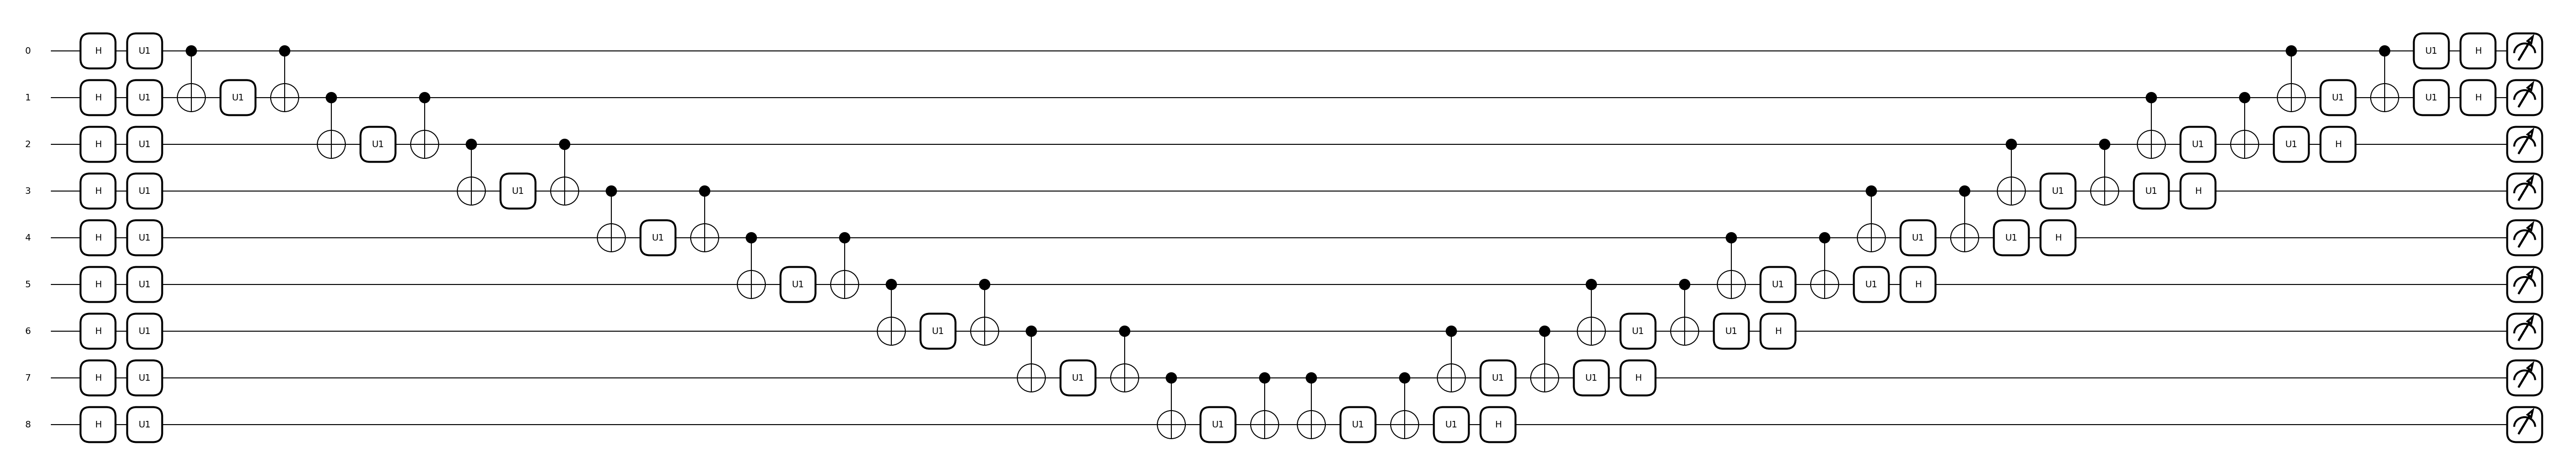

In [3]:
precompute = np.zeros((len(X_train), len(X_train)))
print(qml.draw_mpl(kernel)(X_train[0], X_train[1]))

In [4]:
print(X_train.shape)

(227, 9)


In [5]:
# Define the kernel
@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

(<Figure size 500x1000 with 1 Axes>, <Axes:>)


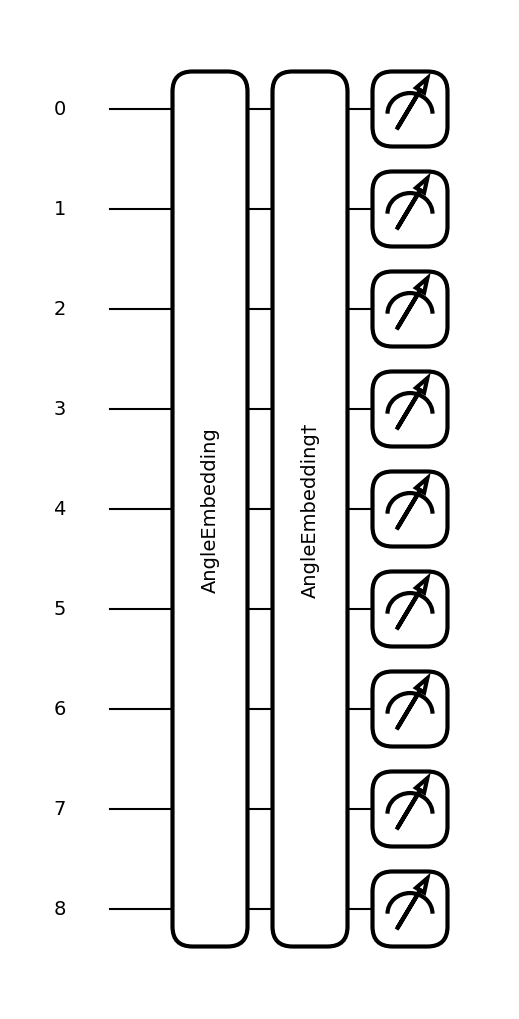

In [6]:
print(qml.draw_mpl(kernel)(X_train[0], X_train[1]))